# FMCW Processing 

- need to understand why a single known target delay can estimate phase errors for ALL frequency bins? 
    - this assumes the phase error is constant across the sweep right? so what if there was a mechanism to estimate phase error for a a target at all ranges? 

    

In [1]:
import numpy as np 
from numpy.fft import fft, ifft
import matplotlib.pyplot as plt
import scipy 
import scipy.constants as sc

In [2]:
# Top Level Constants 
f_c_hz  = 10e9          # Carrier Frequency(hz)
B_hz    = 50e6          # Sweep Bandwidth(hz)
T_s     = 500e-6        # Sweep Period(s)
alpha   = B_hz / T_s    # Chirp Rate i.e. bandwidth over period (Hz/s)
fs = 2.1*(f_c_hz + (B_hz/2)) # Sampling Rate
n_samples = int(T_s*fs)        # num samples 1 period
target_distance_m = 10000 # Example target distance
tau  = (2 * target_distance_m)/sc.speed_of_light # Propogation delay for target

# t = np.linspace(0, 1.2*T_s, 2000) # Time samples for TX 
# t_delayed = t  - tau   # Time samples for RX

In [3]:
def phi_tx(t,f_c_hz, alpha): 
    '''Phase equation for perfectly linear phase
        Args: 
            t(array): time array 
            f_c_hz: carrier freq
            alpha: chirp rate
    '''
    return 2*np.pi * (f_c_hz + (1/2 * alpha*t**2))

/var/folders/41/7_2p9h8s6zzg7br84x60t4lc0000gn/T/ipykernel_96110/2846487358.py:41: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()
/Users/humdaan/repos/fmcw/.venv/lib/python3.12/site-packages/IPython/core/events.py:82: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
/Users/humdaan/repos/fmcw/.venv/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


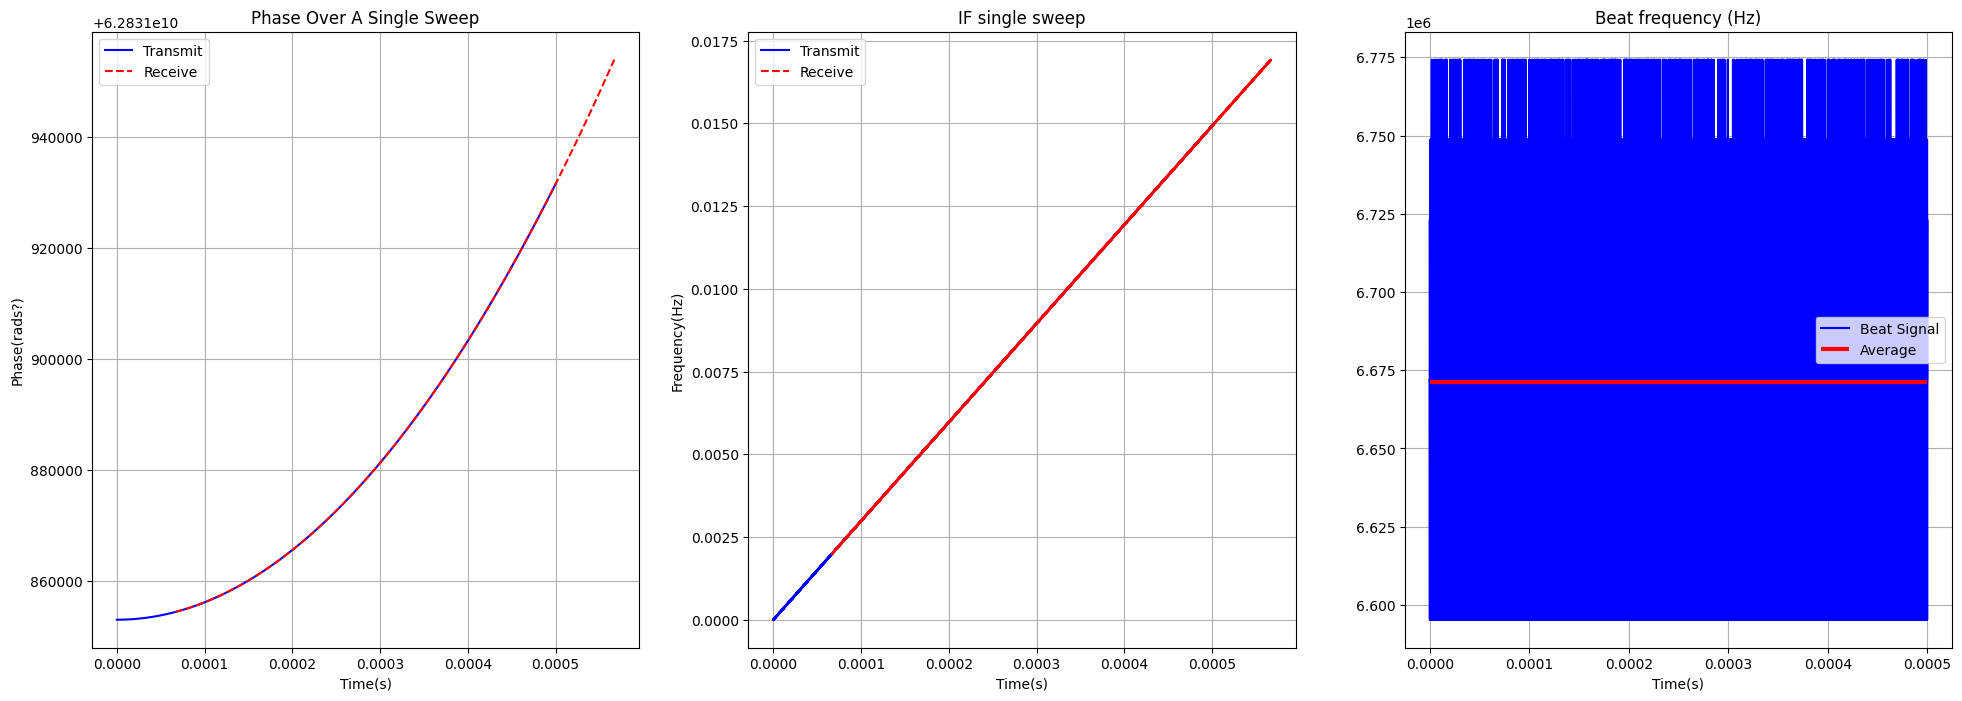

In [4]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize = (24,8))

t_phase = np.linspace(0, T_s, n_samples)
tau_phase_delayed = np.linspace(tau, T_s+tau, n_samples)

# Plot phase 
phase = phi_tx(t_phase, f_c_hz, alpha)
axes[0].plot(t_phase, phase,color='blue', label="Transmit")
phase_tau = phi_tx(tau_phase_delayed, f_c_hz, alpha)
axes[0].plot(tau_phase_delayed, phase_tau,color='red',linestyle="--",label="Receive")

axes[0].set_xlabel("Time(s)")
axes[0].set_ylabel("Phase(rads?)")
axes[0].set_title("Phase Over A Single Sweep")
axes[0].grid()
axes[0].legend()

# Plot Frequency(d/dt of phase)
axes[1].plot(t_phase[1:,], np.diff(phase),color='blue', label="Transmit")
axes[1].plot(tau_phase_delayed[1:,], np.diff(phase_tau),color='red',linestyle="--",label="Receive")
axes[1].set_xlabel("Time(s)")
axes[1].set_ylabel("Frequency(Hz)")
axes[1].set_title("IF single sweep")
axes[1].grid()
axes[1].legend()

# Plot Beat Signal
# below we do phase_tau - phase just to get the right sign convention. mathematically understanding is that it's phase-phase_tau. But in a real mixer, 
# the phase is actually in the cosine,so HW doesn't actually care about the input sign.It's jsut that when we look at the phase directly, we can get the wrong sign. 
phi_b = np.unwrap(phase_tau - phase)  # phase difference
dt = t_phase[1]-t_phase[0]
beat_freq = np.diff(phi_b) / (2*np.pi*dt) 

axes[2].plot(t_phase[1:], beat_freq,  color='blue', label="Beat Signal", zorder=2)
axes[2].hlines(np.mean(beat_freq), 0, t_phase[-1], color='red', label="Average", linewidth=3, zorder=5)
axes[2].set_title("Beat frequency (Hz)")
axes[2].set_xlabel("Time(s)")
axes[2].grid()
axes[2].legend()

fig.show()

/Users/humdaan/repos/fmcw/.venv/lib/python3.12/site-packages/matplotlib/cbook.py:1719: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/Users/humdaan/repos/fmcw/.venv/lib/python3.12/site-packages/matplotlib/cbook.py:1355: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


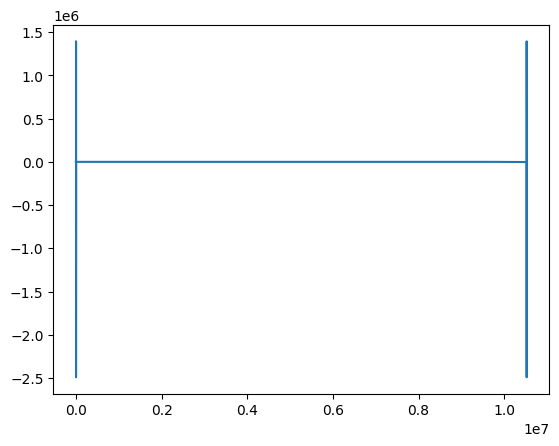

In [123]:
plt.plot(np.fft.fft(np.cos(phi_b)))

/Users/humdaan/repos/fmcw/.venv/lib/python3.12/site-packages/matplotlib/cbook.py:1719: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/Users/humdaan/repos/fmcw/.venv/lib/python3.12/site-packages/matplotlib/cbook.py:1355: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


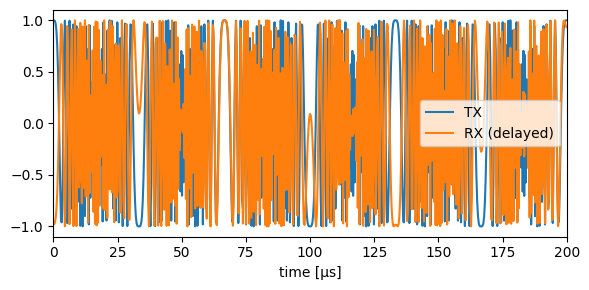

In [38]:
s_tx = np.exp(1j*phi_tx(t,         f_c_hz, alpha))
s_rx = np.exp(1j*phi_tx(t_delayed, f_c_hz, alpha))

plt.figure(figsize=(6,3))
plt.plot(t*1e6, s_tx, label='TX')
plt.plot(t*1e6, np.real(s_rx), label='RX (delayed)')
plt.xlim(0, 200)               # zoom to first 200 µs
plt.xlabel('time [µs]'); plt.legend(); plt.tight_layout()
